1. 하이퍼파라미터별로 성능 파악 
2. 성능이 좋은 것 추려서 random search


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
import os
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix



In [4]:
dfs = pd.read_csv('./processed.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape , dfs.shape

((75000, 23), (25000, 23), (100000, 22))

In [5]:
dfs.head()

,Customer_ID,Month,Age,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,576,1,1,7.509249,3.0,4.0,3.0,0,3.0,7.0,...,2,28.460148,26.822620,1,1,49.574949,21.46538,2,312.494089,2
1,576,2,1,7.509249,3.0,4.0,3.0,0,3.0,4.0,...,2,28.460148,31.944960,1,1,49.574949,21.46538,3,284.629162,2
2,576,3,1,7.509249,3.0,4.0,3.0,0,3.0,7.0,...,2,28.460148,28.609352,1,1,49.574949,21.46538,4,331.209863,2
3,576,4,1,7.509249,3.0,4.0,3.0,0,5.0,4.0,...,2,28.460148,31.377862,1,1,49.574949,21.46538,5,223.451310,2
4,576,5,1,7.509249,3.0,4.0,3.0,0,6.0,4.0,...,2,28.460148,24.797347,1,1,49.574949,21.46538,1,341.489231,2


# 파라미터 조정 이용 함수

In [14]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test, class_weight):
    uncustomized = algorithm(class_weight=class_weight, random_state=0)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    plot_confusion_matrix(uncustomized, # 분류 모델
                             x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             normalize='true') 
    return train_score_before, test_score_before

In [15]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시


In [16]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max,step):
    train_score = []; test_score =[]
    para_n_tree = [n_tree for n_tree in range(n_estimator_min, n_estimator_max+1,step)] # step 5

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=0)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

In [17]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator,step = 5):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max,step)] # step 10

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=0)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=0)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

In [18]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 0)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 0)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

In [19]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=0)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=0)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

In [20]:
def optimi_minimpurity(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf for n_leaf in range(n_leaf_min, n_leaf_max,0.0001)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_impurity_decrease  = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=0)
        else:
            model = algorithm(min_impurity_decrease  = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=0)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_impurity_decrease ': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_impurity_decrease ")
    print(round(df_score_n, 4))

# 목차1


## Processed.csv


In [21]:
# 최종 2개월 valid로 분리
train = dfs.loc[dfs['Month'] <=6]
valid = dfs.loc[dfs['Month'] >6]
train.shape, valid.shape

# train, valid를 각각 x,y 분리

x_train = train.drop(['Credit_Score'],axis=1)
y_train = train['Credit_Score']

x_valid = valid.drop(['Credit_Score'],axis=1)
y_valid = valid['Credit_Score']

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((75000, 21), (75000,), (25000, 21), (25000,))

In [23]:
class

NameError: name 'weight_dict' is not defined

### 바닐라

학습 데이터셋 정확도: 0.9999866666666667
테스트 데이터셋 정확도: 0.7404


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


(0.9999866666666667, 0.7404)

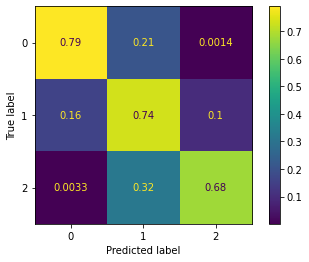

In [ ]:
modeling_uncustomized(RandomForestClassifier,x_train,y_train,x_valid,y_valid,class_weight=class_weight)

   n_estimators  TrainScore  TestScore
0           100         1.0     0.7404
1           150         1.0     0.7415
2           200         1.0     0.7408
3           250         1.0     0.7423
4           300         1.0     0.7410
5           350         1.0     0.7416
6           400         1.0     0.7410


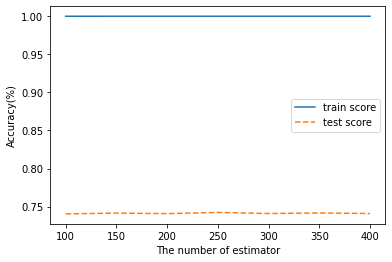

In [ ]:
# default가 100 -> 50 ~ 100 보기
optimi_estimator(RandomForestClassifier, 'rf', x_train, y_train, x_valid, y_valid,100,400,50) # 45 부터 test score 74정도로 비슷 ~ 60 --> d

   n_estimators  TrainScore  TestScore
0             1      0.9057     0.6424
1             2      0.9078     0.6502
2             3      0.9599     0.6821
3             4      0.9630     0.6949
4             5      0.9785     0.7061
5             6      0.9785     0.7110
6             7      0.9859     0.7169
7             8      0.9855     0.7187
8             9      0.9907     0.7210
9            10      0.9902     0.7247


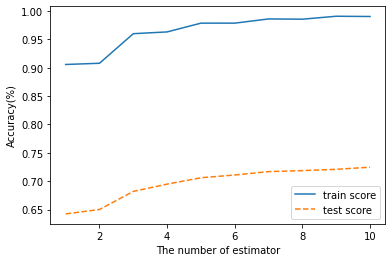

In [ ]:
optimi_estimator(RandomForestClassifier, 'rf', x_train, y_train, x_valid, y_valid,1,10,1) # 이 범위에서도 해봐도 좋을듯??,,


   depth  TrainScore  TestScore
0     10      0.7637     0.6530
1     15      0.8525     0.6922
2     20      0.9513     0.7202
3     25      0.9938     0.7352
4     30      0.9994     0.7388
5     35      0.9997     0.7374
6     40      0.9997     0.7391
7     45      0.9997     0.7388
8     50      0.9997     0.7392
9     55      0.9997     0.7390


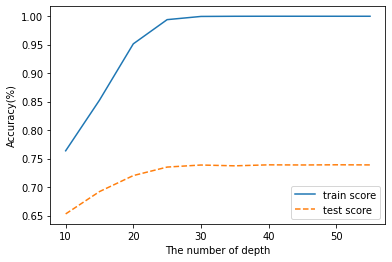

In [ ]:

optimi_maxdepth(RandomForestClassifier,  'rf', 
                x_train, y_train,  x_valid, y_valid,
                10, 60, 45) 
#--> rannge (20,40) -> 30


   min_samples_split  TrainScore  TestScore
0                  2      0.9994     0.7388
1                  4      0.9883     0.7378
2                  6      0.9692     0.7373
3                  8      0.9531     0.7348
4                 10      0.9381     0.7329
5                 12      0.9277     0.7304
6                 14      0.9191     0.7264
7                 16      0.9084     0.7268
8                 18      0.9021     0.7248
9                 20      0.8965     0.7227


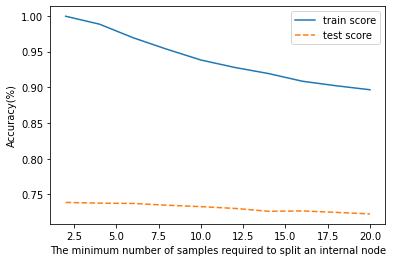

In [ ]:
optimi_minsplit (RandomForestClassifier,  'rf', 
                x_train, y_train,  x_valid, y_valid, 1, 11, 45, 30) 
# best : 2-> 2~6? 까지


   min_samples_leaf  TrainScore  TestScore
0                 2      0.9700     0.7378
1                 4      0.9212     0.7284
2                 6      0.8936     0.7200
3                 8      0.8776     0.7137
4                10      0.8632     0.7086
5                12      0.8547     0.7045
6                14      0.8464     0.7021
7                16      0.8384     0.6959
8                18      0.8318     0.6917


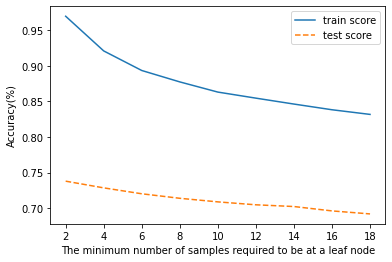

In [ ]:
optimi_minleaf(RandomForestClassifier,  'rf', 
                x_train, y_train,  x_valid, y_valid,  1, 10, 45, 30, 2)
# 2 -> 1~5나 6까지?


학습 데이터셋 정확도: 0.9237066666666667
테스트 데이터셋 정확도: 0.7248


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


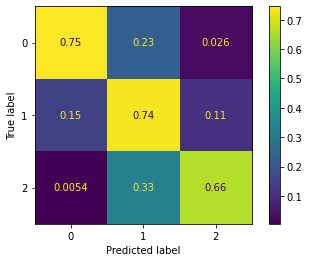

In [ ]:
uncustomized = RandomForestClassifier(random_state=0, n_estimators= 400 , max_depth = 20, min_samples_split=2 , min_samples_leaf=2 )
uncustomized.fit(x_train, y_train)
# Train Data 설명력
train_score_before = uncustomized.score(x_train, y_train)
print(f"학습 데이터셋 정확도: {train_score_before}")
# Test Data 설명력
test_score_before = uncustomized.score(x_valid, y_valid)
print(f"테스트 데이터셋 정확도: {test_score_before}")
plot_confusion_matrix(uncustomized, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 

[0.71644 0.72668 0.72216]
학습 데이터셋 정확도: 0.97004
테스트 데이터셋 정확도: 0.7378


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


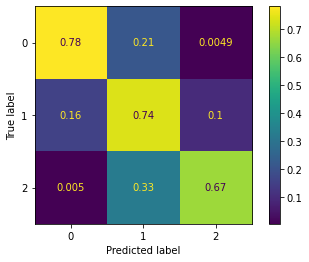

In [ ]:
uncustomized = RandomForestClassifier(random_state=0, n_estimators= 45 , max_depth = 30, min_samples_split=2 , min_samples_leaf=2)
uncustomized.fit(x_train, y_train)
# Train Data 설명력
train_score_before = uncustomized.score(x_train, y_train)
print(f"학습 데이터셋 정확도: {train_score_before}")
# Test Data 설명력
test_score_before = uncustomized.score(x_valid, y_valid)
print(f"테스트 데이터셋 정확도: {test_score_before}")
plot_confusion_matrix(uncustomized, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 


### search

In [ ]:
params = { 'n_estimators' : range(200,401,50), #4
           'max_depth' : range(10,30,5), #4 
           'min_samples_leaf' : range(1,10,2), #5
           'min_samples_split' : range(1,18,2) #5
            }


In [ ]:
forest = RandomForestClassifier(random_state=0,n_jobs=-1)

In [ ]:
#grid
grid = GridSearchCV(forest, param_grid = params, cv = 3, n_jobs = -1)
grid.fit(x_train, y_train)


print('최적 하이퍼 파라미터: ', grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid.best_score_))



In [ ]:
best_grid = grid.best_estimator_
print(best_grid)
print(accuracy_score(y_valid, best_grid.predict(x_valid)))
print(accuracy_score(y_train, best_grid.predict(x_train)))
plot_confusion_matrix(best_grid, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 

In [ ]:
# random search 
best_random = random.best_estimator_
print(accuracy_score(y_valid, best_random.predict(x_valid)))
print(accuracy_score(y_train, best_random.predict(x_train)))
plot_confusion_matrix(best_random, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 
                         

0.69036
0.8264666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


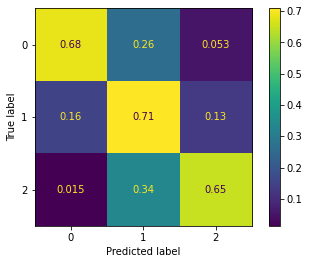

In [ ]:
# random search 
best_grid = grid.best_estimator_
print(best_grid)
print(accuracy_score(y_valid, best_grid.predict(x_valid)))
print(accuracy_score(y_train, best_grid.predict(x_train)))
plot_confusion_matrix(best_grid, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 
                         

In [ ]:
params_1 = { 'n_estimators' : range(1,31,5),
           'max_depth' : range(10,30,5),  
            'min_samples_leaf' : range(1,18,),
           'min_samples_split' : range(1,18,2)
            }


In [ ]:
grid = GridSearchCV(forest, param_grid = params, cv = 3, n_jobs = -1)



In [ ]:
grid.fit(x_train, y_train)
print('최적 하이퍼 파라미터: ', grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid.best_score_))

KeyboardInterrupt: ignored

0.65356
0.75944


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


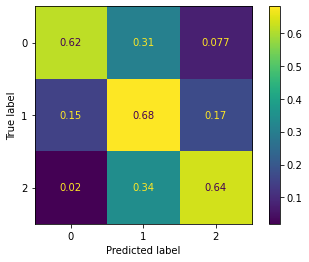

In [ ]:
# random search 
best_random_2 = random_rf_2.best_estimator_
print(accuracy_score(y_valid, best_random_2.predict(x_valid)))
print(accuracy_score(y_train, best_random_2.predict(x_train)))
plot_confusion_matrix(best_random_2, # 분류 모델
                         x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                         normalize='true')  # 더 낮아짐 ㅜ 
                         

In [ ]:
# greed search 
best_grid = grid_rf.best_estimator_
accuracy_score(y_valid, best_grid.predict(x_valid))

In [ ]:
plot_confusion_matrix(best_grid, # 분류 모델
                             x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                             normalize='true') # 

In [ ]:
plot_confusion_matrix(best_random, # 분류 모델
                             x_valid, y_valid, # 예측 데이터와 예측값의 정답(y_true)
                             normalize='true') # 

## 데이터 전처리 많이 안 한것

In [ ]:
origin = pd.read_csv('/content/drive/MyDrive/Credit/archive/train_preprocess_haemin.csv',index_col = 0)


In [ ]:
# 최종 2개월 valid로 분리
train_or = origin.loc[origin['Month'] <=6]
valid_or= origin.loc[origin['Month'] >6]
train_or.shape, valid_or.shape

# train, valid를 각각 x,y 분리

x_train_or = train_or.drop(['Credit_Score'],axis=1)
y_train_or = train_or['Credit_Score']

x_valid_or = valid_or.drop(['Credit_Score'],axis=1)
y_valid_or = valid_or['Credit_Score']

x_train_or.shape, y_train_or.shape, x_valid_or.shape, y_valid_or.shape

In [ ]:
#grid
grid_or = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_or.fit(x_train_or, y_train_or)


print('최적 하이퍼 파라미터: ', grid_or.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_or.best_score_))


In [ ]:
random_or= RandomizedSearchCV(
    rf_clf,
    param_distributions=params, # 파라미터 입력
    n_iter = 500,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='accuracy',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
random_or.fit(x_train_or, y_train_or)
print('최적 하이퍼 파라미터: ', random_or.best_params_)
print('최고 예측 정확도: {:.4f}'.format(random_or.best_score_))

In [ ]:
# greed search 
best_greed_or = grid_or.best_estimator_
print(accuracy_score(y_valid_or, best_grid_or.predict(x_valid_or)))
plot = plot_confusion_matrix(best_grid_or, # 분류 모델
                             x_valid_or, y_valid_or, # 예측 데이터와 예측값의 정답(y_true)
                             normalize='true') # 

In [ ]:
# random search 
best_random_or = random_or.best_estimator_
print(accuracy_score(y_valid_or, best_random.predict(x_valid_or)))
plot = plot_confusion_matrix(best_random_or, # 분류 모델
                             x_valid_or, y_valid_or, # 예측 데이터와 예측값의 정답(y_true)
                             normalize='true') # 

# history age 0/1 나누기


In [ ]:
history_group = dfs.groupby('Credit_History_Age')

In [ ]:
for key , group in history_group:
  if key ==1:
    over_train = group.loc[group['Month']<=6]
    over_valid = group.loc[group['Month']>6]
    over_train_x = over_train.drop(['Credit_Score'],axis=1)
    over_train_y = over_train['Credit_Score']

    over_valid_x = over_valid.drop(['Credit_Score'],axis=1)
    over_valid_y= over_valid['Credit_Score']
  else:
    under_train = group.loc[group['Month']<=6]
    under_valid = group.loc[group['Month']>6]
    under_train_x = under_train.drop(['Credit_Score'],axis=1)
    under_train_y = under_train['Credit_Score']
    under_valid_x = under_valid.drop(['Credit_Score'],axis=1)
    under_valid_y = under_valid['Credit_Score']


In [ ]:
over_grid = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
over_grid.fit(over_train_x, over_train_y)

print('최적 하이퍼 파라미터: ', over_grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(over_grid.best_score_))

In [ ]:

under_grid = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
under_grid.fit(under_train_x, under_train_y)

print('최적 하이퍼 파라미터: ', under_grid.best_params_)
print('최고 예측 정확도: {:.4f}'.format(under_grid.best_score_))

In [ ]:
# greed search 
best_over_grid = over_grid.best_estimator_
print(accuracy_score(over_valid_y, best_over_grid.predict(over_valid_x)))
best_under_grid = under_grid.best_estimator_
print(accuracy_score(under_valid_y, best_under_grid.predict(under_valid_x)))


In [ ]:
valid_y = pd.concat([over_valid_y, under_valid_y])
pred_y = np.concatenate([best_over_grid.predict(over_valid_x),best_under_grid.predict(under_valid_x)])

In [ ]:
cf = confusion_matrix( valid_y,pred_y,normalize = 'true')
sns.heatmap(cf,annot=True)

In [ ]:

over_random= RandomizedSearchCV(
    rf_clf,
    param_distributions=params, # 파라미터 입력
    n_iter = 500,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='accuracy',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
over_random.fit(over_train_x, over_train_y)
print('최적 하이퍼 파라미터: ', over_random.best_params_)
print('최고 예측 정확도: {:.4f}'.format(over_random.best_score_))

In [ ]:

under_random= RandomizedSearchCV(
    rf_clf,
    param_distributions=params, # 파라미터 입력
    n_iter = 500,   # random search 탐색 횟수
    cv = 3,        # cv 검증을 위한 분할 검증 횟수
    scoring='accuracy',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )
under_random.fit(under_train_x, under_train_y)
print('최적 하이퍼 파라미터: ', under_random.best_params_)
print('최고 예측 정확도: {:.4f}'.format(under_random.best_score_))

In [ ]:
# greed search 
best_over_random = over_random.best_estimator_
print(accuracy_score(over_valid_y, best_over_random.predict(over_valid_x)))
best_under_random = under_random.best_estimator_
print(accuracy_score(under_valid_y, best_under_random.predict(under_valid_x)))


In [ ]:
pred_y = np.concatenate([best_over_random.predict(over_valid_x),best_under_random.predict(under_valid_x)])

In [ ]:
cf = confusion_matrix( valid_y,pred_y,normalize = 'true')
sns.heatmap(cf,annot=True)